In [1]:
# !pip install nba-api
# !pip install Keras

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# dependencies

# basic
from datetime import datetime
import json
import pandas as pd
from pandas import ExcelFile
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
import time

# nba api
import nba_api
from nba_api.stats.endpoints import BoxScoreDefensive, BoxScoreMiscV2, BoxScorePlayerTrackV2, BoxScoreUsageV2
from nba_api.stats.static import teams
from nba_api.stats.endpoints import LeagueGameFinder, LeagueGameLog, PlayerGameLog

# sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, Normalizer, StandardScaler
from sklearn.svm import SVC

# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

-------
# csv dataset
-------

In [4]:
# df_final = pd.read_csv('/content/drive/My Drive/mo_bucks_ml/current/gamestatsfinal_version_3.csv')
df_final = pd.read_csv('gamestatsfinal_version_3.csv')

In [5]:
df_final

,AST_PCT,AST_RATIO,AST_TOV,AST,BLK,BLKA,BLK.1,CFGA,CFGM,CFG_PCT,...,TS_TEAM_AVG,UFGA,UFGM,UFG_PCT,USG_PCT,VIDEO_AVAILABLE,WL,YEAR BUILT,ARENA,ATTENDANCE
0,0.214,27.3,3.00,3,0,1,0,2,0,0.000,...,0.480333,5,3,0.600,0.163,1,W,1995,TD Garden,18624
1,0.091,11.1,1.00,2,0,2,0,6,2,0.333,...,0.480333,7,3,0.429,0.229,1,W,1995,TD Garden,18624
2,0.000,0.0,0.00,0,0,1,0,5,1,0.200,...,0.480333,7,3,0.429,0.206,1,W,1995,TD Garden,18624
3,0.095,16.7,0.67,2,4,0,4,3,3,1.000,...,0.480333,4,1,0.250,0.137,1,W,1995,TD Garden,18624
4,0.292,28.0,2.33,7,0,1,0,2,1,0.500,...,0.480333,12,1,0.083,0.247,1,W,1995,TD Garden,18624
5,0.000,0.0,0.00,0,0,0,0,1,1,1.000,...,0.480333,11,6,0.545,0.241,1,W,1995,TD Garden,18624
6,0.000,0.0,0.00,0,0,0,0,0,0,0.000,...,0.480333,0,0,0.000,0.000,1,W,1995,TD Garden,18624
7,0.048,8.3,1.00,1,1,0,1,3,0,0.000,...,0.480333,7,5,0.714,0.167,1,W,1995,TD Garden,18624
8,0.176,30.0,1.50,3,0,0,0,0,0,0.000,...,0.480333,4,2,0.500,0.109,1,W,1995,TD Garden,18624
9,0.250,13.0,3.00,3,0,0,0,5,2,0.400,...,0.480333,12,7,0.583,0.290,1,W,1995,TD Garden,18624


In [6]:
# fix gameid column w/ leading zeros
df_final['GAME_ID'] = df_final['GAME_ID'].map(lambda x: f'{x:0>10}')

In [7]:
df_final.head()

,AST_PCT,AST_RATIO,AST_TOV,AST,BLK,BLKA,BLK.1,CFGA,CFGM,CFG_PCT,...,TS_TEAM_AVG,UFGA,UFGM,UFG_PCT,USG_PCT,VIDEO_AVAILABLE,WL,YEAR BUILT,ARENA,ATTENDANCE
0,0.214,27.3,3.00,3,0,1,0,2,0,0.000,...,0.480333,5,3,0.600,0.163,1,W,1995,TD Garden,18624
1,0.091,11.1,1.00,2,0,2,0,6,2,0.333,...,0.480333,7,3,0.429,0.229,1,W,1995,TD Garden,18624
2,0.000,0.0,0.00,0,0,1,0,5,1,0.200,...,0.480333,7,3,0.429,0.206,1,W,1995,TD Garden,18624
3,0.095,16.7,0.67,2,4,0,4,3,3,1.000,...,0.480333,4,1,0.250,0.137,1,W,1995,TD Garden,18624
4,0.292,28.0,2.33,7,0,1,0,2,1,0.500,...,0.480333,12,1,0.083,0.247,1,W,1995,TD Garden,18624


# player selection

In [9]:
# dfplayerawards = pd.read_csv('/content/drive/My Drive/mo_bucks_ml/current/2019_nba_awards.csv')
dfplayerawards = pd.read_csv('2019_nba_awards.csv')

In [10]:
players_awarded = dfplayerawards['Player'].unique()

In [11]:
df_final_awarded = df_final.loc[df_final['PLAYER_NAME'].isin(players_awarded)]

# feature selection

In [12]:
list(df_final.keys())

['AST_PCT',
 'AST_RATIO',
 'AST_TOV',
 'AST',
 'BLK',
 'BLKA',
 'BLK.1',
 'CFGA',
 'CFGM',
 'CFG_PCT',
 'COMMENT',
 'Capacity',
 'Capacity_pct',
 'City',
 'DEF_RATING',
 'DFGA',
 'DFGM',
 'DFG_PCT',
 'DIST',
 'DRBC',
 'DREB_PCT',
 'DREB',
 'EFG_EVAL',
 'EFG_PCT',
 'EFG_TEAM_AVG',
 'E_DEF_RATING',
 'E_NET_RATING',
 'E_OFF_RATING',
 'E_PACE',
 'E_USG_PCT',
 'FG3A',
 'FG3M',
 'FG3_PCT',
 'FGA',
 'FGM',
 'FG_PCT',
 'FTA',
 'FTAST',
 'FTM',
 'FT_PCT',
 'FT_missed',
 'GAME_DATE',
 'GAME_ID',
 'GAMESCORE',
 'Home/Away',
 'Hometeam',
 'MATCHUP',
 'MATCHUP_AST',
 'MATCHUP_FG3A',
 'MATCHUP_FG3M',
 'MATCHUP_FG3_PCT',
 'MATCHUP_FGA',
 'MATCHUP_FGM',
 'MATCHUP_FG_PCT',
 'MATCHUP_MIN',
 'MATCHUP_TOV',
 'MIN',
 'MIN_FLAT',
 'NET_RATING',
 'OFF_RATING',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_FB',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_PAINT',
 'ORBC',
 'OREB',
 'OREB_PCT',
 'PACE',
 'PACE_PER40',
 'PARTIAL_POSS',
 'PASS',
 'PCT_AST',
 'PCT_BLK',
 'PCT_BLKA',
 'PCT_DREB',
 'PCT_FG3A',
 'PCT_FG3M',
 'PCT_FGA',
 'PCT_F

In [13]:
features = [
    
#   target
    'START_POSITION',
    
#   categorical
    'WL',
    
#   traditional
    'PTS',
    'AST',
    'PF',
#   'DEF_RATING',
#   'OFF_RATING',
    'FG_PCT',
    'FG3M',
    'FTM',
    'FGM',
    'STL',
    'TOV',
    'Home/Away',
    
#   minutes/usage/possession
    'MIN_FLAT',
    'USG_PCT',
    'POSS',
    
#   point types
    'PTS_2ND_CHANCE',
    'PTS_FB',
    'PTS_OFF_TOV',
    'PTS_PAINT',

#   advanced
    'GAMESCORE',
    'EFG_PCT',
    'TS_PCT',
#   eval => pct above or below team average
    'EFG_EVAL',
    'TS_EVAL',
    
#   granular
    'SPD', # speed
    'DIST', # distance
    'ORBC', # oreb chances
    'DRBC', # dreb chances
    'RBC', # reb chances
    'TCHS', # touches
    'SAST', # secondary assists
    'FTAST', # free throw assists
    'PFD', # personal fouls drawn
    'PASS', # passes
    'CFGM', # contested fgm
    'CFGA', # contested fga
    'CFG_PCT', # contested fg pct
    'UFGM', # uncontested fgm
    'UFGA', # uncontested fga
    'UFG_PCT', # uncontested fg pct
    'DFGM', # defended fgm
    'DFGA', # defended fga
    'DFG_PCT', # defended df pct
    
#   percent of team stats
    'PCT_FGM',
    'PCT_FGA',
    'PCT_FG3M',
    'PCT_FG3A',
    'PCT_FTM',
    'PCT_FTA',
    'PCT_OREB',
    'PCT_DREB',
    'PCT_REB',
    'PCT_AST',
    'PCT_TOV',
    'PCT_STL',
    'PCT_BLK',
    'PCT_BLKA',
    'PCT_PF',
    'PCT_PFD',
    'PCT_PTS',
    
#     arena
#    'Capacity_pct',
#    'Capacity',
    
]

In [14]:
len(features)

60

--------
# svc model
--------

In [15]:
df_svc = df_final[features].copy()

In [22]:
df_svc = df_svc[pd.notnull(df_svc['START_POSITION'])]

In [23]:
df_svc.head()

,START_POSITION,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,...,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS
1,G,W,12,2,4,0.385,1,1,5,0,...,0.083,0.172,0.105,0.286,0.000,0.0,0.667,0.364,0.077,0.171
2,F,W,10,0,1,0.333,1,1,4,4,...,0.143,0.172,0.000,0.000,0.667,0.0,0.500,0.111,0.385,0.192
3,C,W,9,2,1,0.571,0,1,4,0,...,0.138,0.121,0.118,0.300,0.000,1.0,0.000,0.091,0.143,0.134
4,G,W,7,7,1,0.143,1,2,2,0,...,0.154,0.129,0.389,0.333,0.000,0.0,0.250,0.077,0.143,0.103
9,F,W,23,3,2,0.529,1,4,9,1,...,0.269,0.300,0.300,0.091,0.250,0.0,0.000,0.167,0.231,0.426


In [24]:
positions = df_svc['START_POSITION'].unique()
positions

array(['G', 'F', 'C'], dtype=object)

In [25]:
encoder = LabelEncoder()
encoder.fit(df_svc['START_POSITION'])
y = encoder.transform(df_svc['START_POSITION'])
df_svc['START_POSITION'] = y

In [26]:
encoder = LabelEncoder()
encoder.fit(df_svc['WL'])
wl = encoder.transform(df_svc.WL)
df_svc['WL'] = wl

In [27]:
encoder = LabelEncoder()
encoder.fit(df_svc['Home/Away'])
home = encoder.transform(df_svc['Home/Away'])
df_svc['HOME'] = home

In [28]:
df_svc

,START_POSITION,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,...,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME
1,2,1,12,2,4,0.385,1,1,5,0,...,0.172,0.105,0.286,0.000,0.000,0.667,0.364,0.077,0.171,1
2,1,1,10,0,1,0.333,1,1,4,4,...,0.172,0.000,0.000,0.667,0.000,0.500,0.111,0.385,0.192,1
3,0,1,9,2,1,0.571,0,1,4,0,...,0.121,0.118,0.300,0.000,1.000,0.000,0.091,0.143,0.134,1
4,2,1,7,7,1,0.143,1,2,2,0,...,0.129,0.389,0.333,0.000,0.000,0.250,0.077,0.143,0.103,1
9,1,1,23,3,2,0.529,1,4,9,1,...,0.300,0.300,0.091,0.250,0.000,0.000,0.167,0.231,0.426,1
13,1,0,8,0,1,0.300,2,0,3,2,...,0.167,0.000,0.200,0.333,0.333,0.000,0.077,0.071,0.119,0
14,0,0,23,2,3,0.429,1,4,9,1,...,0.250,0.133,0.385,0.200,0.400,0.750,0.200,0.214,0.333,0
15,2,0,5,2,1,0.286,0,1,2,1,...,0.115,0.222,0.273,0.500,0.000,0.000,0.100,0.250,0.119,0
19,1,0,6,1,5,0.375,0,0,3,0,...,0.273,0.125,0.375,0.000,0.000,0.000,0.455,0.091,0.136,0
21,2,0,19,8,5,0.500,0,5,7,4,...,0.333,0.471,0.231,0.500,0.400,0.200,0.294,0.444,0.238,0


In [29]:
target = df_svc['START_POSITION']
data = df_svc.drop(['START_POSITION', 'Home/Away'], axis=1)
feature_names = data.columns

In [30]:
data

,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,...,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME
1,1,12,2,4,0.385,1,1,5,0,2,...,0.172,0.105,0.286,0.000,0.000,0.667,0.364,0.077,0.171,1
2,1,10,0,1,0.333,1,1,4,4,0,...,0.172,0.000,0.000,0.667,0.000,0.500,0.111,0.385,0.192,1
3,1,9,2,1,0.571,0,1,4,0,3,...,0.121,0.118,0.300,0.000,1.000,0.000,0.091,0.143,0.134,1
4,1,7,7,1,0.143,1,2,2,0,3,...,0.129,0.389,0.333,0.000,0.000,0.250,0.077,0.143,0.103,1
9,1,23,3,2,0.529,1,4,9,1,1,...,0.300,0.300,0.091,0.250,0.000,0.000,0.167,0.231,0.426,1
13,0,8,0,1,0.300,2,0,3,2,2,...,0.167,0.000,0.200,0.333,0.333,0.000,0.077,0.071,0.119,0
14,0,23,2,3,0.429,1,4,9,1,5,...,0.250,0.133,0.385,0.200,0.400,0.750,0.200,0.214,0.333,0
15,0,5,2,1,0.286,0,1,2,1,3,...,0.115,0.222,0.273,0.500,0.000,0.000,0.100,0.250,0.119,0
19,0,6,1,5,0.375,0,0,3,0,3,...,0.273,0.125,0.375,0.000,0.000,0.000,0.455,0.091,0.136,0
21,0,19,8,5,0.500,0,5,7,4,3,...,0.333,0.471,0.231,0.500,0.400,0.200,0.294,0.444,0.238,0


In [31]:
# X_train, X_test, y_train, y_test = train_test_split(data[:5000], target[:5000], random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [32]:
y_train.head()

6931     1
16333    2
4641     2
9557     1
8894     1
Name: START_POSITION, dtype: int64

In [33]:
y_test.head()

12634    2
8877     1
11022    1
14432    1
10912    1
Name: START_POSITION, dtype: int64

In [34]:
X_test

,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,...,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME
12634,1,9,1,4,0.600,3,0,3,0,1,...,0.056,0.100,0.100,0.000,0.000,0.000,0.286,0.000,0.205,0
8877,0,13,8,4,0.417,3,0,5,3,2,...,0.143,0.308,0.200,0.300,0.000,0.000,0.267,0.071,0.160,1
11022,1,21,1,2,0.474,1,2,9,1,1,...,0.138,0.040,0.077,0.071,0.000,0.200,0.125,0.231,0.239,1
14432,1,15,2,1,0.444,0,7,4,0,1,...,0.524,0.333,0.167,0.000,0.000,0.250,0.100,0.556,0.405,0
10912,0,10,1,0,0.231,1,3,3,1,0,...,0.300,0.143,0.000,0.143,0.000,0.333,0.000,0.214,0.169,0
14738,1,14,0,3,0.545,0,2,6,2,1,...,0.167,0.000,0.143,0.182,1.000,1.000,0.375,0.214,0.255,1
11072,0,14,1,2,0.500,3,1,5,1,0,...,0.259,0.067,0.000,0.500,0.000,0.000,0.167,0.077,0.212,0
9592,0,4,2,2,0.200,0,2,1,1,3,...,0.158,0.167,0.333,0.200,0.250,0.000,0.250,0.167,0.078,1
7039,1,14,0,6,0.556,0,4,5,0,1,...,0.480,0.000,0.111,0.000,1.000,0.000,0.400,0.333,0.215,0
8330,1,12,2,1,0.625,2,0,5,0,2,...,0.107,0.125,0.400,0.000,0.000,0.000,0.091,0.077,0.164,1


In [35]:
model = SVC(C= 5, 
        gamma= 0.01, 
        kernel= 'rbf',
        verbose=True)

In [36]:
model.fit(X_train, y_train)

[LibSVM]

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [37]:
predictions_svc = model.predict(X_test)

In [38]:
X_test['predictions_svc'] = predictions_svc
X_test['target'] = target

/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
X_test

,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,...,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME,predictions_svc,target
12634,1,9,1,4,0.600,3,0,3,0,1,...,0.100,0.000,0.000,0.000,0.286,0.000,0.205,0,1,2
8877,0,13,8,4,0.417,3,0,5,3,2,...,0.200,0.300,0.000,0.000,0.267,0.071,0.160,1,1,1
11022,1,21,1,2,0.474,1,2,9,1,1,...,0.077,0.071,0.000,0.200,0.125,0.231,0.239,1,1,1
14432,1,15,2,1,0.444,0,7,4,0,1,...,0.167,0.000,0.000,0.250,0.100,0.556,0.405,0,0,1
10912,0,10,1,0,0.231,1,3,3,1,0,...,0.000,0.143,0.000,0.333,0.000,0.214,0.169,0,1,1
14738,1,14,0,3,0.545,0,2,6,2,1,...,0.143,0.182,1.000,1.000,0.375,0.214,0.255,1,0,1
11072,0,14,1,2,0.500,3,1,5,1,0,...,0.000,0.500,0.000,0.000,0.167,0.077,0.212,0,1,1
9592,0,4,2,2,0.200,0,2,1,1,3,...,0.333,0.200,0.250,0.000,0.250,0.167,0.078,1,2,2
7039,1,14,0,6,0.556,0,4,5,0,1,...,0.111,0.000,1.000,0.000,0.400,0.333,0.215,0,0,0
8330,1,12,2,1,0.625,2,0,5,0,2,...,0.400,0.000,0.000,0.000,0.091,0.077,0.164,1,1,1


In [48]:
print(classification_report(y_test, predictions_svc, target_names=['Center','Forward','Guard']))

              precision    recall  f1-score   support

      Center       0.71      0.64      0.67       567
     Forward       0.60      0.59      0.59      1212
       Guard       0.66      0.70      0.68      1158

    accuracy                           0.64      2937
   macro avg       0.65      0.64      0.65      2937
weighted avg       0.64      0.64      0.64      2937



In [49]:
list(features)

['START_POSITION',
 'WL',
 'PTS',
 'AST',
 'PF',
 'FG_PCT',
 'FG3M',
 'FTM',
 'FGM',
 'STL',
 'TOV',
 'Home/Away',
 'MIN_FLAT',
 'USG_PCT',
 'POSS',
 'PTS_2ND_CHANCE',
 'PTS_FB',
 'PTS_OFF_TOV',
 'PTS_PAINT',
 'GAMESCORE',
 'EFG_PCT',
 'TS_PCT',
 'EFG_EVAL',
 'TS_EVAL',
 'SPD',
 'DIST',
 'ORBC',
 'DRBC',
 'RBC',
 'TCHS',
 'SAST',
 'FTAST',
 'PFD',
 'PASS',
 'CFGM',
 'CFGA',
 'CFG_PCT',
 'UFGM',
 'UFGA',
 'UFG_PCT',
 'DFGM',
 'DFGA',
 'DFG_PCT',
 'PCT_FGM',
 'PCT_FGA',
 'PCT_FG3M',
 'PCT_FG3A',
 'PCT_FTM',
 'PCT_FTA',
 'PCT_OREB',
 'PCT_DREB',
 'PCT_REB',
 'PCT_AST',
 'PCT_TOV',
 'PCT_STL',
 'PCT_BLK',
 'PCT_BLKA',
 'PCT_PF',
 'PCT_PFD',
 'PCT_PTS']

In [43]:
dfpred = pd.concat([df_final, X_test], axis=1)

In [53]:
dfplayerpred = dfpred[['START_POSITION','PLAYER_NAME', 'TEAM_NICKNAME', 'MATCHUP', 'predictions_svc', 'target']].copy().dropna()

In [54]:
dfplayerpred

,START_POSITION,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_svc,target
1,G,Jaylen Brown,Celtics,BOS vs. PHI,1.0,2.0
4,G,Kyrie Irving,Celtics,BOS vs. PHI,2.0,2.0
19,F,Dario Saric,76ers,PHI @ BOS,0.0,1.0
24,G,Stephen Curry,Warriors,GSW vs. OKC,1.0,2.0
31,G,Klay Thompson,Warriors,GSW vs. OKC,2.0,2.0
39,G,Dennis Schroder,Thunder,OKC @ GSW,2.0,2.0
47,C,Brook Lopez,Bucks,MIL @ CHA,2.0,0.0
59,C,Cody Zeller,Hornets,CHA vs. MIL,1.0,0.0
63,F,Jared Dudley,Nets,BKN @ DET,1.0,1.0
65,F,Joe Harris,Nets,BKN @ DET,1.0,1.0


In [55]:
dfplayerpred['correct_svc'] = 0

In [56]:
for index, row in dfplayerpred.iterrows():
    
    if row['predictions_svc'] == row['target']:
        dfplayerpred.loc[index, 'correct_svc'] = 'correct'
    if row['predictions_svc'] != row['target']:
        dfplayerpred.loc[index, 'correct_svc'] = 'wrong'

In [57]:
dfplayerpred.loc[(dfplayerpred['correct_svc'] == 'correct')]

,START_POSITION,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_svc,target,correct_svc
4,G,Kyrie Irving,Celtics,BOS vs. PHI,2.0,2.0,correct
31,G,Klay Thompson,Warriors,GSW vs. OKC,2.0,2.0,correct
39,G,Dennis Schroder,Thunder,OKC @ GSW,2.0,2.0,correct
63,F,Jared Dudley,Nets,BKN @ DET,1.0,1.0,correct
65,F,Joe Harris,Nets,BKN @ DET,1.0,1.0,correct
67,G,Caris LeVert,Nets,BKN @ DET,2.0,2.0,correct
69,G,Bruce Brown,Pistons,DET vs. BKN,2.0,2.0,correct
70,C,Andre Drummond,Pistons,DET vs. BKN,0.0,0.0,correct
74,F,Luke Kennard,Pistons,DET vs. BKN,1.0,1.0,correct
94,F,Chandler Parsons,Grizzlies,MEM @ IND,1.0,1.0,correct


## grid

In [58]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [59]:
model = SVC()

# param_grid = {'C': [0.001, 0.1, 1, 5, 10, 100],
#               'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
#               'kernel':['rbf']}

param_grid = {'C': [0.1, 1, 5],
              'gamma': [0.001, 0.01, 0.1, 1],
              'kernel':['rbf']}

grid = GridSearchCV(model, param_grid, verbose=3)

In [ ]:
grid.fit(X_train, y_train)

/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.665, total=   2.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.664, total=   2.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.681, total=   2.7s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.543, total=   3.7s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.534, total=   3.8s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.541, total=   3.8s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.404, total=   4.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.404, total=   4.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.404, total=   4.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .

In [273]:
grid.best_params_

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

In [274]:
grid.best_score_

0.6289381563593932

In [0]:
predictions_grid = grid.predict(X_test)

In [276]:
predictions_grid

array([0, 0, 1, ..., 0, 1, 1])

In [277]:
X_test['predictions_grid'] = predictions_grid
X_test['target'] = target

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [278]:
print(classification_report(y_test, predictions_grid,
                            target_names=["loss", "win"]))

              precision    recall  f1-score   support

        loss       0.63      0.43      0.52       538
         win       0.61      0.78      0.68       605

    accuracy                           0.62      1143
   macro avg       0.62      0.61      0.60      1143
weighted avg       0.62      0.62      0.60      1143



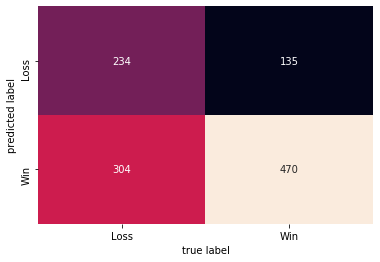

In [279]:
matrix = confusion_matrix(y_test, predictions_grid)
sns.heatmap(matrix.T, annot=True, fmt='d', cbar=False,
            xticklabels=['Loss', 'Win'],
            yticklabels=['Loss', 'Win'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [280]:
matrix.T

array([[234, 135],
       [304, 470]])

In [0]:
dfpred = pd.concat([df_final, X_test], axis=1)

In [282]:
dfpred

,AST_PCT,AST_RATIO,AST_TOV,AST,BLK,BLKA,BLK.1,CFGA,CFGM,CFG_PCT,COMMENT,Capacity,Capacity_pct,City,DEF_RATING,DFGA,DFGM,DFG_PCT,DIST,DRBC,DREB_PCT,DREB,EFG_EVAL,EFG_PCT,EFG_TEAM_AVG,E_DEF_RATING,E_NET_RATING,E_OFF_RATING,E_PACE,E_USG_PCT,FG3A,FG3M,FG3_PCT,FGA,FGM,FG_PCT,FTA,FTAST,FTM,FT_PCT,...,TS_EVAL,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PFD,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,PCT_FGM,PCT_FGA,PCT_FG3M,PCT_FG3A,PCT_FTM,PCT_FTA,PCT_OREB,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME,predictions_grid,target
4,0.292,28.0,2.33,7,0,1,0,2,1,0.500,NaN,18624,1.000000,Boston Massachusetts,89.4,1,1,1.000,2.25,7,0.118,4,-0.291417,0.179,0.470417,87.3,12.1,99.4,112.55,0.245,8,1,0.125,14,2,0.143,2,0,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.176,30.0,1.50,3,0,0,0,0,0,0.000,NaN,18624,1.000000,Boston Massachusetts,78.2,2,2,1.000,1.81,7,0.103,3,0.279583,0.750,0.470417,80.2,5.5,85.8,102.94,0.110,4,2,0.500,4,2,0.500,2,0,1,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,0.105,6.7,0.40,2,2,3,2,14,6,0.429,NaN,18624,1.000000,Boston Massachusetts,93.9,7,2,0.286,2.48,14,0.167,8,0.163600,0.452,0.288400,92.7,-8.7,84.0,107.72,0.321,4,1,0.250,21,9,0.429,5,0,4,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,0.000,0.0,0.00,0,0,0,0,0,0,0.000,NaN,18624,1.000000,Boston Massachusetts,115.4,0,0,0.000,1.02,1,0.091,1,-0.288400,0.000,0.288400,126.3,-37.7,88.6,91.73,0.186,2,0,0.000,4,0,0.000,2,0,1,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,0.346,27.3,3.00,9,0,0,0,11,6,0.545,NaN,19596,1.000000,Oakland California,92.6,0,0,0.000,2.92,14,0.160,8,0.264200,0.675,0.410800,92.7,15.9,108.6,107.32,0.245,9,5,0.556,20,11,0.550,5,0,5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22439,0.200,16.7,2.00,2,2,0,2,2,1,0.500,NaN,19068,0.925897,Los Angeles California,131.4,4,0,0.000,1.25,7,0.176,3,0.348625,0.875,0.526375,128.6,-0.3,128.3,108.95,0.254,6,4,0.667,8,5,0.625,3,0,3,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22451,0.000,0.0,0.00,0,0,1,0,6,4,0.667,NaN,19441,1.019186,Portland Oregon,139.7,3,1,0.333,2.26,10,0.360,9,-0.077091,0.600,0.677091,141.8,-8.0,133.8,99.63,0.238,5,2,0.400,15,8,0.533,2,0,2,1.0,...,-0.058818,4.17,2.26,6.0,10.0,15.0,53.0,1.0,0.0,5.0,34.0,4.0,6.0,0.667,4.0,9.0,0.444,1.0,3.0,0.333,0.250,0.250,0.154,0.179,0.250,0.25,0.000,0.692,0.429,0.000,0.125,0.333,0.0,1.0,0.154,0.417,0.235,0.0,1.0,0.0
22455,0.000,0.0,0.00,0,0,0,0,1,1,1.000,NaN,19441,1.019186,Portland Oregon,127.0,2,1,0.500,1.22,5,0.214,3,0.322909,1.000,0.677091,124.9,47.6,172.5,102.68,0.101,0,0,0.000,3,3,1.000,2,0,2,1.0,...,0.342182,4.00,1.22,4.0,5.0,9.0,16.0,0.0,0.0,1.0,12.0,1.0,1.0,1.000,2.0,2.0,1.000,1.0,2.0,0.500,0.125,0.088,0.000,0.000,0.333,0.25,0.667,0.273,0.357,0.000,0.000,0.000,0.0,0.0,0.400,0.200,0.127,0.0,0.0,0.0
22457,0.600,45.0,9.00,9,0,0,0,4,4,1.000,NaN,19441,1.019186,Portland Oregon,122.9,0,0,0.000,1.20,1,0.067,1,0.172909,0.850,0.677091,120.7,59.0,179.6,100.73,0.293,1,1,1.

In [0]:
dfplayerpred = dfpred[['PLAYER_NAME', 'TEAM_NICKNAME', 'MATCHUP', 'predictions_grid', 'target', 'WL']].copy().dropna()

In [284]:
dfplayerpred

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_grid,target,WL
31,Klay Thompson,Warriors,GSW vs. OKC,0.0,1.0,W
40,Giannis Antetokounmpo,Bucks,MIL @ CHA,1.0,1.0,W
57,Kemba Walker,Hornets,CHA vs. MIL,1.0,0.0,L
62,Spencer Dinwiddie,Nets,BKN @ DET,0.0,0.0,L
72,Blake Griffin,Pistons,DET vs. BKN,1.0,1.0,W
...,...,...,...,...,...,...
22427,Danilo Gallinari,Clippers,LAC vs. UTA,1.0,1.0,W
22432,Landry Shamet,Clippers,LAC vs. UTA,1.0,1.0,W
22451,Marvin Bagley III,Kings,SAC @ POR,1.0,0.0,L
22455,Willie Cauley-Stein,Kings,SAC @ POR,0.0,0.0,L


In [0]:
dfplayerpred['correct_grid'] = 0
dfplayerpred['wrong_grid'] = 0

In [286]:
for index, row in dfplayerpred.iterrows():
    
    if row[3] == row['target']:
        dfplayerpred.loc[index, 'correct_grid'] = 1
        
    if row[3] != row['target']:
        dfplayerpred.loc[index, 'wrong_grid'] = 1

    print(index, row[6])

31 0
40 0
57 0
62 0
72 0
93 0
110 0
125 0
135 0
145 0
151 0
200 0
207 0
210 0
224 0
228 0
260 0
306 0
349 0
353 0
368 0
406 0
431 0
444 0
455 0
457 0
461 0
470 0
471 0
527 0
537 0
545 0
592 0
602 0
671 0
676 0
678 0
692 0
706 0
720 0
723 0
725 0
726 0
739 0
748 0
799 0
805 0
818 0
848 0
863 0
866 0
872 0
875 0
896 0
901 0
923 0
927 0
932 0
943 0
949 0
981 0
986 0
1020 0
1039 0
1061 0
1077 0
1109 0
1121 0
1128 0
1150 0
1154 0
1157 0
1219 0
1220 0
1227 0
1243 0
1275 0
1308 0
1333 0
1348 0
1390 0
1407 0
1410 0
1420 0
1431 0
1450 0
1452 0
1455 0
1510 0
1531 0
1535 0
1552 0
1553 0
1560 0
1572 0
1580 0
1600 0
1607 0
1610 0
1612 0
1688 0
1695 0
1713 0
1717 0
1720 0
1745 0
1779 0
1786 0
1807 0
1844 0
1883 0
1927 0
1949 0
1980 0
1989 0
2001 0
2006 0
2009 0
2064 0
2076 0
2087 0
2097 0
2107 0
2112 0
2127 0
2137 0
2152 0
2159 0
2190 0
2207 0
2219 0
2222 0
2233 0
2256 0
2259 0
2291 0
2327 0
2343 0
2377 0
2384 0
2389 0
2408 0
2431 0
2435 0
2466 0
2494 0
2550 0
2562 0
2582 0
2592 0
2629 0
2638 0
2655

In [287]:
dfplayerpred

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_grid,target,WL,correct_grid,wrong_grid
31,Klay Thompson,Warriors,GSW vs. OKC,0.0,1.0,W,0,1
40,Giannis Antetokounmpo,Bucks,MIL @ CHA,1.0,1.0,W,1,0
57,Kemba Walker,Hornets,CHA vs. MIL,1.0,0.0,L,0,1
62,Spencer Dinwiddie,Nets,BKN @ DET,0.0,0.0,L,1,0
72,Blake Griffin,Pistons,DET vs. BKN,1.0,1.0,W,1,0
...,...,...,...,...,...,...,...,...
22427,Danilo Gallinari,Clippers,LAC vs. UTA,1.0,1.0,W,1,0
22432,Landry Shamet,Clippers,LAC vs. UTA,1.0,1.0,W,1,0
22451,Marvin Bagley III,Kings,SAC @ POR,1.0,0.0,L,0,1
22455,Willie Cauley-Stein,Kings,SAC @ POR,0.0,0.0,L,1,0


In [0]:
groupbygrid = dfplayerpred.groupby(by='PLAYER_NAME').sum()[['correct_grid', 'wrong_grid']].copy()

In [0]:
df = pd.DataFrame(groupbygrid)
df['differential_grid'] = 0
df['correct_grid_pct'] = 0
df['wrong_grid_pct'] = 0

In [0]:
for index, row in df.iterrows():
    differential = (row['correct_grid'] - row['wrong_grid']) / (row['correct_grid'] + row['wrong_grid'])
    df.loc[index, 'differential_grid'] = differential
    
    correct_pct = (row['correct_grid']) / (row['correct_grid'] + row['wrong_grid'])
    df.loc[index, 'correct_grid_pct'] = correct_pct

    wrong_pct = (row['wrong_grid']) / (row['correct_grid'] + row['wrong_grid'])
    df.loc[index, 'wrong_grid_pct'] = wrong_pct


In [291]:
df.sort_values(by='correct_grid_pct').tail(20)

,correct_grid,wrong_grid,differential_grid,correct_grid_pct,wrong_grid_pct
PLAYER_NAME,,,,,
Buddy Hield,15,7,0.363636,0.681818,0.318182
Lou Williams,11,5,0.375000,0.687500,0.312500
Nikola Jokic,11,5,0.375000,0.687500,0.312500
Bojan Bogdanovic,11,5,0.375000,0.687500,0.312500
Montrezl Harrell,19,8,0.407407,0.703704,0.296296
Pascal Siakam,12,5,0.411765,0.705882,0.294118
Paul George,12,5,0.411765,0.705882,0.294118
Collin Sexton,15,6,0.428571,0.714286,0.285714
Russell Westbrook,10,4,0.428571,0.714286,0.285714


In [292]:
df.sort_values(by='wrong_grid_pct').head(20)

,correct_grid,wrong_grid,differential_grid,correct_grid_pct,wrong_grid_pct
PLAYER_NAME,,,,,
John Collins,11,1,0.833333,0.916667,0.083333
Jarrett Allen,17,3,0.700000,0.850000,0.150000
Draymond Green,13,3,0.625000,0.812500,0.187500
Stephen Curry,17,4,0.619048,0.809524,0.190476
Jrue Holiday,12,3,0.600000,0.800000,0.200000
De'Aaron Fox,12,3,0.600000,0.800000,0.200000
Andre Iguodala,17,5,0.545455,0.772727,0.227273
Mitchell Robinson,17,5,0.545455,0.772727,0.227273
Joel Embiid,13,4,0.529412,0.764706,0.235294


----------
# neural net
----------

In [0]:
df_nnet = df_final[features]

In [0]:
data = df_nnet.copy()

In [295]:
data.head()

,WL,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,Home/Away,MIN_FLAT,USG_PCT,POSS,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,GAMESCORE,EFG_PCT,TS_PCT,EFG_EVAL,TS_EVAL,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PFD,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,PCT_FGM,PCT_FGA,PCT_FG3M,PCT_FG3A,PCT_FTM,PCT_FTA,PCT_OREB,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS
4,W,7,7,1,0.143,1,2,2,0,3,HOME,29,0.247,66,0,0,0,2,0.7,0.179,0.235,-0.291417,-0.245333,4.33,2.25,2,7,9,81,1,0,2,63,1,2,0.500,1,12,0.083,1,1,1.000,0.077,0.233,0.125,0.308,0.250,0.200,0.0,0.154,0.129,0.389,0.333,0.000,0.0,0.25,0.077,0.143,0.103
8,W,7,3,2,0.500,2,1,2,0,2,HOME,25,0.109,53,3,0,0,0,4.8,0.750,0.717,0.279583,0.236667,4.02,1.81,0,7,7,36,0,0,1,30,0,0,0.000,2,4,0.500,2,2,1.000,0.105,0.078,0.400,0.222,0.333,0.333,0.0,0.130,0.091,0.429,0.200,0.000,0.0,0.00,0.182,0.125,0.152
14,L,23,2,3,0.429,1,4,9,1,5,AWAY,37,0.301,85,0,6,2,16,12.9,0.452,0.496,0.163600,0.188300,3.73,2.48,6,14,20,77,0,0,3,49,6,14,0.429,3,7,0.429,2,7,0.286,0.321,0.309,0.200,0.174,0.500,0.357,0.4,0.229,0.250,0.133,0.385,0.200,0.4,0.75,0.200,0.214,0.333
20,L,1,0,0,0.000,0,1,0,0,0,AWAY,13,0.172,27,0,0,0,0,-1.9,0.000,0.102,-0.288400,-0.205700,4.46,1.02,0,1,1,15,0,0,1,11,0,0,0.000,0,4,0.000,0,0,0.000,0.000,0.200,0.000,0.500,0.143,0.182,0.0,0.167,0.125,0.000,0.000,0.000,0.0,0.00,0.000,0.125,0.045
24,W,32,9,4,0.550,5,5,11,1,3,HOME,37,0.240,82,6,10,8,10,27.5,0.675,0.721,0.264200,0.290100,4.48,2.92,3,14,17,85,0,0,4,58,6,11,0.545,5,9,0.556,0,0,0.000,0.297,0.256,0.833,0.450,0.500,0.455,0.0,0.242,0.167,0.360,0.200,0.167,0.0,0.00,0.182,0.308,0.356


In [296]:
encoder = LabelEncoder()
encoder.fit(data['WL'])
encoder.classes_
y = encoder.transform(data.WL)
y

array([1, 1, 0, ..., 0, 0, 0])

In [0]:
encoder = LabelEncoder()
encoder.fit(data['Home/Away'])
home = encoder.transform(data['Home/Away'])
data['HOME'] = home

In [298]:
data.drop(columns=['WL','Home/Away'], inplace=True)
# X = data.values
X = data
X

,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,MIN_FLAT,USG_PCT,POSS,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,GAMESCORE,EFG_PCT,TS_PCT,EFG_EVAL,TS_EVAL,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PFD,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,PCT_FGM,PCT_FGA,PCT_FG3M,PCT_FG3A,PCT_FTM,PCT_FTA,PCT_OREB,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME
4,7,7,1,0.143,1,2,2,0,3,29,0.247,66,0,0,0,2,0.7,0.179,0.235,-0.291417,-0.245333,4.33,2.25,2,7,9,81,1,0,2,63,1,2,0.500,1,12,0.083,1,1,1.000,0.077,0.233,0.125,0.308,0.250,0.200,0.000,0.154,0.129,0.389,0.333,0.000,0.0,0.25,0.077,0.143,0.103,1
8,7,3,2,0.500,2,1,2,0,2,25,0.109,53,3,0,0,0,4.8,0.750,0.717,0.279583,0.236667,4.02,1.81,0,7,7,36,0,0,1,30,0,0,0.000,2,4,0.500,2,2,1.000,0.105,0.078,0.400,0.222,0.333,0.333,0.000,0.130,0.091,0.429,0.200,0.000,0.0,0.00,0.182,0.125,0.152,1
14,23,2,3,0.429,1,4,9,1,5,37,0.301,85,0,6,2,16,12.9,0.452,0.496,0.163600,0.188300,3.73,2.48,6,14,20,77,0,0,3,49,6,14,0.429,3,7,0.429,2,7,0.286,0.321,0.309,0.200,0.174,0.500,0.357,0.400,0.229,0.250,0.133,0.385,0.200,0.4,0.75,0.200,0.214,0.333,0
20,1,0,0,0.000,0,1,0,0,0,13,0.172,27,0,0,0,0,-1.9,0.000,0.102,-0.288400,-0.205700,4.46,1.02,0,1,1,15,0,0,1,11,0,0,0.000,0,4,0.000,0,0,0.000,0.000,0.200,0.000,0.500,0.143,0.182,0.000,0.167,0.125,0.000,0.000,0.000,0.0,0.00,0.000,0.125,0.045,0
24,32,9,4,0.550,5,5,11,1,3,37,0.240,82,6,10,8,10,27.5,0.675,0.721,0.264200,0.290100,4.48,2.92,3,14,17,85,0,0,4,58,6,11,0.545,5,9,0.556,0,0,0.000,0.297,0.256,0.833,0.450,0.500,0.455,0.000,0.242,0.167,0.360,0.200,0.167,0.0,0.00,0.182,0.308,0.356,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22439,17,2,1,0.625,4,3,5,0,1,16,0.250,37,3,3,3,0,15.7,0.875,0.912,0.348625,0.335625,4.37,1.25,0,7,7,37,1,0,2,27,1,2,0.500,4,6,0.667,0,4,0.000,0.333,0.286,0.500,0.375,0.300,0.300,0.000,0.250,0.214,0.154,0.143,0.000,1.0,0.00,0.200,0.333,0.354,0
22451,20,0,2,0.533,2,2,8,1,1,30,0.233,63,2,4,2,8,14.6,0.600,0.630,-0.077091,-0.058818,4.17,2.26,6,10,15,53,1,0,5,34,4,6,0.667,4,9,0.444,1,3,0.333,0.250,0.250,0.154,0.179,0.250,0.250,0.000,0.692,0.429,0.000,0.125,0.333,0.0,1.00,0.154,0.417,0.235,0
22455,8,0,2,1.000,0,2,3,0,0,17,0.098,37,2,0,0,6,8.6,1.000,1.031,0.322909,0.342182,4.00,1.22,4,5,9,16,0,0,1,12,1,1,1.000,2,2,1.000,1,2,0.500,0.125,0.088,0.000,0.000,0.333,0.250,0.667,0.273,0.357,0.000,0.000,0.000,0.0,0.00,0.400,0.200,0.127,0
22457,17,9,1,0.800,1,0,8,0,1,17,0.282,35,3,0,5,14,18.4,0.850,0.850,0.172909,0.161182,4.08,1.20,1,1,2,36,0,0,1,24,4,4,1.000,4,6,0.667,0,0,0.000,0.348,0.313,0.100,0.071,0.000,0.000,0.000,0.091,0.071,0.600,0.500,0.000,0.0,0.00,0.250,0.200,0.274,0


In [299]:
len(y), len(X)

(4571, 4571)

In [300]:
y_categorical = to_categorical(y)
y_categorical

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, random_state=42)

In [0]:
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

# X_scaler = StandardScaler().fit(X_train)
# y_scaler = StandardScaler().fit(y_train)

In [0]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [0]:
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [305]:
X_train_scaled[0]

array([0.04918033, 0.08333333, 0.33333333, 0.25      , 0.        ,
       0.04545455, 0.04761905, 0.125     , 0.        , 0.45454545,
       0.13518198, 0.41176471, 0.        , 0.11764706, 0.11764706,
       0.06666667, 0.18739353, 0.16666667, 0.20466667, 0.19436746,
       0.22605001, 0.79182879, 0.43691589, 0.16666667, 0.16666667,
       0.21621622, 0.13605442, 0.        , 0.        , 0.06666667,
       0.14141414, 0.        , 0.08695652, 0.        , 0.05882353,
       0.07407407, 0.5       , 0.16666667, 0.0952381 , 1.        ,
       0.043     , 0.091     , 0.        , 0.091     , 0.083     ,
       0.125     , 0.182     , 0.13768961, 0.17875   , 0.2       ,
       0.        , 0.333     , 0.333     , 0.        , 0.167     ,
       0.091     , 0.048     , 0.        ])

In [306]:
y_train_scaled[0]

array([1., 0.], dtype=float32)

In [307]:
X_train_scaled.shape, y_train_scaled.shape

((3428, 58), (3428, 2))

In [0]:
model = Sequential(name='NBA_Model')

# input layer
model.add(Dense(units=50, activation='relu', input_dim=X_train_scaled.shape[1], kernel_initializer='he_normal'))

# hidden layers
model.add(Dense(units=100, activation='relu'))
# model.add(Dense(units=100, activation='relu'))
# model.add(Dense(units=75, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=25, activation='relu'))

# output layer
# model.add(Dense(units=y_train.shape[1], activation='sigmoid'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

In [309]:
model.summary()

Model: "NBA_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 50)                2950      
_________________________________________________________________
dense_38 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_39 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_40 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 52        
Total params: 14,427
Trainable params: 14,427
Non-trainable params: 0
_________________________________________________________________


In [0]:
optimizer_sgd = SGD(lr = 0.01, 
                    momentum = 0.9)

In [0]:
model.compile(
#     optimizer='adam',
    optimizer=optimizer_sgd,
    loss='binary_crossentropy',
#     loss='categorical_crossentropy',
    # loss='categorical_hinge',
    metrics=['accuracy']
)

In [312]:
model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=50,
    shuffle=True,
    verbose=2,
    validation_data=[X_test_scaled, y_test_scaled]
)

Train on 3428 samples, validate on 1143 samples
Epoch 1/50
3428/3428 - 0s - loss: 0.6760 - acc: 0.5659 - val_loss: 0.6688 - val_acc: 0.5862
Epoch 2/50
3428/3428 - 0s - loss: 0.6561 - acc: 0.6126 - val_loss: 0.6578 - val_acc: 0.5993
Epoch 3/50
3428/3428 - 0s - loss: 0.6441 - acc: 0.6219 - val_loss: 0.6619 - val_acc: 0.5853
Epoch 4/50
3428/3428 - 0s - loss: 0.6406 - acc: 0.6257 - val_loss: 0.6453 - val_acc: 0.6142
Epoch 5/50
3428/3428 - 0s - loss: 0.6336 - acc: 0.6374 - val_loss: 0.6451 - val_acc: 0.6159
Epoch 6/50
3428/3428 - 0s - loss: 0.6202 - acc: 0.6511 - val_loss: 0.6265 - val_acc: 0.6378
Epoch 7/50
3428/3428 - 0s - loss: 0.6161 - acc: 0.6561 - val_loss: 0.6364 - val_acc: 0.6203
Epoch 8/50
3428/3428 - 0s - loss: 0.5981 - acc: 0.6651 - val_loss: 0.6007 - val_acc: 0.6614
Epoch 9/50
3428/3428 - 0s - loss: 0.5844 - acc: 0.6922 - val_loss: 0.6092 - val_acc: 0.6728
Epoch 10/50
3428/3428 - 0s - loss: 0.5910 - acc: 0.6774 - val_loss: 0.6121 - val_acc: 0.6649
Epoch 11/50
3428/3428 - 0s - lo

In [313]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_scaled, verbose=2)
print(f"Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

1143/1143 - 0s - loss: 0.6954 - acc: 0.6317
Neural Network - Loss: 0.695417480935992, Accuracy: 0.6316710114479065


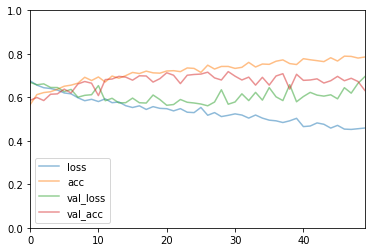

In [314]:
pd.DataFrame(model.history.history).plot(alpha=.5)
plt.gca().set_ylim(0,1)
plt.show()

In [315]:
predictions_nnet = model.predict(X_test_scaled)
predictions_nnet

array([[0.0755445 , 0.92445546],
       [0.2807926 , 0.7192074 ],
       [0.7997886 , 0.20021142],
       ...,
       [0.14756633, 0.8524337 ],
       [0.44376674, 0.5562332 ],
       [0.34304023, 0.6569598 ]], dtype=float32)

In [316]:
# add predictions to df here and merge with grid pred df
X_test['nnet_pred_loss_0'] = predictions_nnet[:,0]
X_test['nnet_pred_win_1'] = predictions_nnet[:,1]
X_test['WL_TARGET'] = y_test[:,1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [317]:
X_test

,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,MIN_FLAT,USG_PCT,POSS,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,GAMESCORE,EFG_PCT,TS_PCT,EFG_EVAL,TS_EVAL,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PFD,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,PCT_FGM,PCT_FGA,PCT_FG3M,PCT_FG3A,PCT_FTM,PCT_FTA,PCT_OREB,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME,nnet_pred_loss_0,nnet_pred_win_1,WL_TARGET
7450,6,2,2,0.600,0,0,3,0,1,22,0.122,43,0,0,0,6,6.3,0.600,0.600,0.156222,0.124444,3.82,1.48,3,5,8,31,0,0,1,23,2,4,0.500,1,1,1.000,2,3,0.667,0.150,0.128,0.000,0.000,0.000,0.000,0.000,0.250,0.167,0.167,0.125,0.000,1.000,0.500,0.222,0.111,0.128,1,0.075544,0.924455,0.0
93,10,1,2,0.333,0,6,2,3,0,25,0.145,53,4,0,2,4,12.5,0.333,0.579,-0.009625,0.169750,4.16,1.85,5,6,11,40,0,0,4,32,2,5,0.400,0,1,0.000,4,5,0.800,0.182,0.146,0.000,0.111,0.429,0.353,0.500,0.231,0.294,0.200,0.000,0.750,1.000,0.000,0.200,0.308,0.256,0,0.280793,0.719207,0.0
1220,4,0,0,1.000,0,0,2,0,0,11,0.080,21,0,2,0,4,4.0,1.000,1.000,0.433900,0.421700,4.15,0.76,0,4,4,9,0,0,0,6,1,1,1.000,1,1,1.000,0,0,0.000,0.200,0.118,0.000,0.000,0.000,0.000,0.000,0.222,0.182,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.138,0,0.799789,0.200211,0.0
12957,16,1,2,0.857,0,4,6,0,0,26,0.190,52,0,2,2,12,14.4,0.857,0.760,0.305625,0.194500,3.89,1.80,6,9,14,32,0,0,5,20,4,5,0.800,2,2,1.000,6,8,0.750,0.261,0.159,0.000,0.000,0.364,0.444,0.333,0.200,0.217,0.077,0.000,0.000,0.500,0.000,0.133,0.417,0.262,0,0.074990,0.925010,1.0
19448,14,7,0,0.333,1,5,4,4,4,32,0.256,72,2,4,2,6,12.9,0.375,0.427,0.004625,0.046500,4.21,2.45,5,13,18,76,1,1,7,54,3,6,0.500,1,6,0.167,0,0,0.000,0.143,0.194,0.077,0.171,0.385,0.500,0.111,0.250,0.216,0.412,0.400,0.571,0.000,0.500,0.000,0.467,0.171,1,0.303065,0.696935,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10692,8,0,4,0.429,1,1,3,1,2,34,0.116,77,0,0,0,4,4.0,0.500,0.508,-0.044556,-0.057222,4.39,2.68,3,9,12,23,1,0,2,11,2,3,0.667,1,4,0.250,2,6,0.333,0.088,0.106,0.111,0.182,0.077,0.111,0.000,0.057,0.048,0.000,0.200,0.143,0.333,0.500,0.222,0.143,0.089,1,0.120248,0.879752,1.0
11899,14,0,4,0.556,0,4,5,1,2,20,0.269,45,2,1,3,8,9.8,0.556,0.579,-0.016818,-0.008818,4.40,1.60,4,8,12,62,0,0,6,48,3,6,0.500,2,3,0.667,2,5,0.400,0.313,0.243,0.000,0.000,0.333,0.438,0.400,0.316,0.333,0.000,0.250,0.333,0.333,0.000,0.444,0.400,0.304,1,0.076352,0.923648,1.0
8851,19,5,2,0.467,3,2,7,1,2,30,0.237,66,1,6,2,8,14.2,0.567,0.567,0.020625,-0.003625,4.15,2.17,3,7,10,74,2,0,5,54,3,5,0.600,4,10,0.400,1,1,1.000,0.280,0.254,0.333,0.250,0.182,0.250,0.143,0.087,0.100,0.313,0.250,0.200,0.333,0.333,0.222,0.357,0.271,0,0.147566,0.852434,0.0
3315,24,5,0,0.409,1,5,9,2,1,39,0.294,78,4,4,6,14,19.5,0.432,0.496,-0.167125,-0.101375,4.19,2.89,4,13,16,68,3,0,2,41,5,9,0.556,4,13,0.308,0,0,0.000,0.273,0.328,0.167,0.250,0.357,0.250,0.200,0.250,0.242,0.333,0.125,0.500,0.000,0.500,0.000,0.133,0.279,1,0.443767,0.556233,1.0


In [0]:
dfprednnet = pd.concat([df_final, X_test], axis=1)[['PLAYER_NAME', 'TEAM_NICKNAME', 'MATCHUP', 'nnet_pred_loss_0', 'nnet_pred_win_1', 'WL_TARGET', 'WL']].copy().dropna()

In [319]:
dfprednnet

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,nnet_pred_loss_0,nnet_pred_win_1,WL_TARGET,WL
31,Klay Thompson,Warriors,GSW vs. OKC,0.663354,0.336646,1.0,W
40,Giannis Antetokounmpo,Bucks,MIL @ CHA,0.429282,0.570718,1.0,W
57,Kemba Walker,Hornets,CHA vs. MIL,0.176738,0.823262,0.0,L
62,Spencer Dinwiddie,Nets,BKN @ DET,0.330874,0.669126,0.0,L
72,Blake Griffin,Pistons,DET vs. BKN,0.340975,0.659025,1.0,W
...,...,...,...,...,...,...,...
22427,Danilo Gallinari,Clippers,LAC vs. UTA,0.062916,0.937084,1.0,W
22432,Landry Shamet,Clippers,LAC vs. UTA,0.051255,0.948745,1.0,W
22451,Marvin Bagley III,Kings,SAC @ POR,0.307614,0.692386,0.0,L
22455,Willie Cauley-Stein,Kings,SAC @ POR,0.071423,0.928577,0.0,L


In [0]:
dfprednnet['nnet_eval'] = 0
dfprednnet['nnet_total'] = 1

In [321]:
dfprednnet

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,nnet_pred_loss_0,nnet_pred_win_1,WL_TARGET,WL,nnet_eval,nnet_total
31,Klay Thompson,Warriors,GSW vs. OKC,0.663354,0.336646,1.0,W,0,1
40,Giannis Antetokounmpo,Bucks,MIL @ CHA,0.429282,0.570718,1.0,W,0,1
57,Kemba Walker,Hornets,CHA vs. MIL,0.176738,0.823262,0.0,L,0,1
62,Spencer Dinwiddie,Nets,BKN @ DET,0.330874,0.669126,0.0,L,0,1
72,Blake Griffin,Pistons,DET vs. BKN,0.340975,0.659025,1.0,W,0,1
...,...,...,...,...,...,...,...,...,...
22427,Danilo Gallinari,Clippers,LAC vs. UTA,0.062916,0.937084,1.0,W,0,1
22432,Landry Shamet,Clippers,LAC vs. UTA,0.051255,0.948745,1.0,W,0,1
22451,Marvin Bagley III,Kings,SAC @ POR,0.307614,0.692386,0.0,L,0,1
22455,Willie Cauley-Stein,Kings,SAC @ POR,0.071423,0.928577,0.0,L,0,1


In [0]:
for index, row in dfprednnet.iterrows():
    
    if dfprednnet.loc[index, 'nnet_pred_loss_0'] > 0.5 and row['WL_TARGET'] == 0.0:
        dfprednnet.loc[index, 'nnet_eval'] = 1
    
    if dfprednnet.loc[index, 'nnet_pred_win_1'] > 0.5 and row['WL_TARGET'] == 1.0:
        dfprednnet.loc[index, 'nnet_eval'] = 1


In [323]:
dfprednnet

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,nnet_pred_loss_0,nnet_pred_win_1,WL_TARGET,WL,nnet_eval,nnet_total
31,Klay Thompson,Warriors,GSW vs. OKC,0.663354,0.336646,1.0,W,0,1
40,Giannis Antetokounmpo,Bucks,MIL @ CHA,0.429282,0.570718,1.0,W,1,1
57,Kemba Walker,Hornets,CHA vs. MIL,0.176738,0.823262,0.0,L,0,1
62,Spencer Dinwiddie,Nets,BKN @ DET,0.330874,0.669126,0.0,L,0,1
72,Blake Griffin,Pistons,DET vs. BKN,0.340975,0.659025,1.0,W,1,1
...,...,...,...,...,...,...,...,...,...
22427,Danilo Gallinari,Clippers,LAC vs. UTA,0.062916,0.937084,1.0,W,1,1
22432,Landry Shamet,Clippers,LAC vs. UTA,0.051255,0.948745,1.0,W,1,1
22451,Marvin Bagley III,Kings,SAC @ POR,0.307614,0.692386,0.0,L,0,1
22455,Willie Cauley-Stein,Kings,SAC @ POR,0.071423,0.928577,0.0,L,0,1


In [324]:
dfprednnet['nnet_eval'].value_counts() / len(dfprednnet['nnet_eval'])

1    0.631671
0    0.368329
Name: nnet_eval, dtype: float64

In [325]:
len(dfprednnet['nnet_eval'])

1143

In [0]:
groupbynnet = dfprednnet.groupby(by='PLAYER_NAME').sum()[['nnet_eval','nnet_total']].copy()

In [327]:
groupbynnet

,nnet_eval,nnet_total
PLAYER_NAME,,
Andre Iguodala,21,22
Blake Griffin,14,17
Bojan Bogdanovic,13,16
Bryn Forbes,15,22
Buddy Hield,12,22
...,...,...
Terrence Ross,10,18
Thomas Bryant,11,19
Trae Young,11,18


In [0]:
dfnnet = pd.DataFrame(groupbynnet)
dfnnet['differential_nnet'] = 0
dfnnet['nnet_wrong'] = 0
dfnnet['nnet_wrong_pct'] = 0
dfnnet['nnet_correct_pct'] = 0

for index, row in dfnnet.iterrows():
    
    total_nnet = row['nnet_total']
    
    correct_nnet = row['nnet_eval']
    
    wrong_nnet = total_nnet - correct_nnet
    dfnnet.loc[index, 'nnet_wrong'] = wrong_nnet
    
    differential_nnet = (correct_nnet - wrong_nnet) / total_nnet
    dfnnet.loc[index, 'differential_nnet'] = differential_nnet
    
    correct_pct = correct_nnet / total_nnet
    dfnnet.loc[index, 'nnet_correct_pct'] = correct_pct

    wrong_pct = wrong_nnet / total_nnet
    dfnnet.loc[index, 'nnet_wrong_pct'] = wrong_pct

In [329]:
# dfnnet.sort_values(by='differential_nnet').head(20)
dfnnet

,nnet_eval,nnet_total,differential_nnet,nnet_wrong,nnet_wrong_pct,nnet_correct_pct
PLAYER_NAME,,,,,,
Andre Iguodala,21,22,0.909091,1,0.045455,0.954545
Blake Griffin,14,17,0.647059,3,0.176471,0.823529
Bojan Bogdanovic,13,16,0.625000,3,0.187500,0.812500
Bryn Forbes,15,22,0.363636,7,0.318182,0.681818
Buddy Hield,12,22,0.090909,10,0.454545,0.545455
...,...,...,...,...,...,...
Terrence Ross,10,18,0.111111,8,0.444444,0.555556
Thomas Bryant,11,19,0.157895,8,0.421053,0.578947
Trae Young,11,18,0.222222,7,0.388889,0.611111


## predictions df

In [330]:
df

,correct_grid,wrong_grid,differential_grid,correct_grid_pct,wrong_grid_pct
PLAYER_NAME,,,,,
Andre Iguodala,17,5,0.545455,0.772727,0.227273
Blake Griffin,10,7,0.176471,0.588235,0.411765
Bojan Bogdanovic,11,5,0.375000,0.687500,0.312500
Bryn Forbes,13,9,0.181818,0.590909,0.409091
Buddy Hield,15,7,0.363636,0.681818,0.318182
...,...,...,...,...,...
Terrence Ross,10,8,0.111111,0.555556,0.444444
Thomas Bryant,9,10,-0.052632,0.473684,0.526316
Trae Young,11,7,0.222222,0.611111,0.388889


In [331]:
dfnnet

,nnet_eval,nnet_total,differential_nnet,nnet_wrong,nnet_wrong_pct,nnet_correct_pct
PLAYER_NAME,,,,,,
Andre Iguodala,21,22,0.909091,1,0.045455,0.954545
Blake Griffin,14,17,0.647059,3,0.176471,0.823529
Bojan Bogdanovic,13,16,0.625000,3,0.187500,0.812500
Bryn Forbes,15,22,0.363636,7,0.318182,0.681818
Buddy Hield,12,22,0.090909,10,0.454545,0.545455
...,...,...,...,...,...,...
Terrence Ross,10,18,0.111111,8,0.444444,0.555556
Thomas Bryant,11,19,0.157895,8,0.421053,0.578947
Trae Young,11,18,0.222222,7,0.388889,0.611111


In [0]:
df_prediction_eval = pd.concat([df, dfnnet], axis=1)[['nnet_correct_pct', 'correct_grid_pct']]

In [333]:
print('Neural Net Worst:')
df_prediction_eval.sort_values(by='nnet_correct_pct')

Neural Net Worst:


,nnet_correct_pct,correct_grid_pct
PLAYER_NAME,,
Derrick Rose,0.083333,0.583333
Ed Davis,0.294118,0.235294
LeBron James,0.333333,0.333333
Jaren Jackson Jr.,0.363636,0.545455
Luka Doncic,0.391304,0.434783
...,...,...
Damian Lillard,0.857143,0.666667
Draymond Green,0.875000,0.812500
Joel Embiid,0.882353,0.764706


In [334]:
print('SVM Worst:')
df_prediction_eval.sort_values(by='correct_grid_pct')

SVM Worst:


,nnet_correct_pct,correct_grid_pct
PLAYER_NAME,,
Ed Davis,0.294118,0.235294
LeBron James,0.333333,0.333333
Klay Thompson,0.647059,0.352941
Deandre Ayton,0.476190,0.380952
Luka Doncic,0.391304,0.434783
...,...,...
De'Aaron Fox,0.733333,0.800000
Stephen Curry,0.904762,0.809524
Draymond Green,0.875000,0.812500


In [335]:
print('Neural Net Best:')
df_prediction_eval.sort_values(by='nnet_correct_pct', ascending=False)

Neural Net Best:


,nnet_correct_pct,correct_grid_pct
PLAYER_NAME,,
Andre Iguodala,0.954545,0.772727
Stephen Curry,0.904762,0.809524
Joel Embiid,0.882353,0.764706
Draymond Green,0.875000,0.812500
Damian Lillard,0.857143,0.666667
...,...,...
Luka Doncic,0.391304,0.434783
Jaren Jackson Jr.,0.363636,0.545455
LeBron James,0.333333,0.333333


In [336]:
print('SVM Best:')
df_prediction_eval.sort_values(by='correct_grid_pct', ascending=False)

SVM Best:


,nnet_correct_pct,correct_grid_pct
PLAYER_NAME,,
John Collins,0.750000,0.916667
Jarrett Allen,0.500000,0.850000
Draymond Green,0.875000,0.812500
Stephen Curry,0.904762,0.809524
Jrue Holiday,0.600000,0.800000
...,...,...
Luka Doncic,0.391304,0.434783
Deandre Ayton,0.476190,0.380952
Klay Thompson,0.647059,0.352941


# random forest

In [0]:
df_forest = df_final[features].copy()

In [0]:
target = df_forest["WL"]
target_names = ["W", "L"]

In [0]:
encoder = LabelEncoder()
encoder.fit(df_forest['Home/Away'])
home = encoder.transform(df_forest['Home/Away'])
df_forest['HOME'] = home

In [340]:
data = df_forest.drop(["WL",'Home/Away'], axis=1)
feature_names = data.columns
data.head()

,PTS,AST,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,MIN_FLAT,USG_PCT,POSS,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,GAMESCORE,EFG_PCT,TS_PCT,EFG_EVAL,TS_EVAL,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PFD,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,PCT_FGM,PCT_FGA,PCT_FG3M,PCT_FG3A,PCT_FTM,PCT_FTA,PCT_OREB,PCT_DREB,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,HOME
4,7,7,1,0.143,1,2,2,0,3,29,0.247,66,0,0,0,2,0.7,0.179,0.235,-0.291417,-0.245333,4.33,2.25,2,7,9,81,1,0,2,63,1,2,0.500,1,12,0.083,1,1,1.000,0.077,0.233,0.125,0.308,0.250,0.200,0.0,0.154,0.129,0.389,0.333,0.000,0.0,0.25,0.077,0.143,0.103,1
8,7,3,2,0.500,2,1,2,0,2,25,0.109,53,3,0,0,0,4.8,0.750,0.717,0.279583,0.236667,4.02,1.81,0,7,7,36,0,0,1,30,0,0,0.000,2,4,0.500,2,2,1.000,0.105,0.078,0.400,0.222,0.333,0.333,0.0,0.130,0.091,0.429,0.200,0.000,0.0,0.00,0.182,0.125,0.152,1
14,23,2,3,0.429,1,4,9,1,5,37,0.301,85,0,6,2,16,12.9,0.452,0.496,0.163600,0.188300,3.73,2.48,6,14,20,77,0,0,3,49,6,14,0.429,3,7,0.429,2,7,0.286,0.321,0.309,0.200,0.174,0.500,0.357,0.4,0.229,0.250,0.133,0.385,0.200,0.4,0.75,0.200,0.214,0.333,0
20,1,0,0,0.000,0,1,0,0,0,13,0.172,27,0,0,0,0,-1.9,0.000,0.102,-0.288400,-0.205700,4.46,1.02,0,1,1,15,0,0,1,11,0,0,0.000,0,4,0.000,0,0,0.000,0.000,0.200,0.000,0.500,0.143,0.182,0.0,0.167,0.125,0.000,0.000,0.000,0.0,0.00,0.000,0.125,0.045,0
24,32,9,4,0.550,5,5,11,1,3,37,0.240,82,6,10,8,10,27.5,0.675,0.721,0.264200,0.290100,4.48,2.92,3,14,17,85,0,0,4,58,6,11,0.545,5,9,0.556,0,0,0.000,0.297,0.256,0.833,0.450,0.500,0.455,0.0,0.242,0.167,0.360,0.200,0.167,0.0,0.00,0.182,0.308,0.356,1


In [0]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [342]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5993000874890638

In [343]:
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.6622922134733158

In [344]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.038573376214213126, 'GAMESCORE'),
 (0.03111866573323124, 'TS_PCT'),
 (0.02923837198791233, 'TS_EVAL'),
 (0.028409181088771378, 'PCT_PTS'),
 (0.02831342101287503, 'EFG_EVAL'),
 (0.0269159403863104, 'PCT_FGM'),
 (0.02651226151547721, 'DIST'),
 (0.025830536177100117, 'EFG_PCT'),
 (0.025271074614797544, 'SPD'),
 (0.02327738624312524, 'HOME'),
 (0.02291759036116066, 'PCT_REB'),
 (0.022846309934201246, 'PCT_FGA'),
 (0.022212509129802254, 'TCHS'),
 (0.021728243637715118, 'USG_PCT'),
 (0.02150402719228317, 'PASS'),
 (0.02146059307206077, 'POSS'),
 (0.021425907126826734, 'FG_PCT'),
 (0.02140006807359864, 'PCT_DREB'),
 (0.021031040271169296, 'PCT_PF'),
 (0.02075724642742193, 'PCT_AST'),
 (0.020098586846459248, 'PCT_FG3A'),
 (0.01887514853430008, 'DRBC'),
 (0.01836484810803315, 'PCT_PFD'),
 (0.017609751099779483, 'MIN_FLAT'),
 (0.017371409748215272, 'PCT_FTA'),
 (0.017358364476267873, 'RBC'),
 (0.01704708907888459, 'PTS'),
 (0.016578161300987777, 'UFG_PCT'),
 (0.0162783213376404, 'PCT_TOV'),
